# WEEK 4: Feature Engineering and Model Training

In [5]:
# Import libraries
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

In [6]:
# Read datasets
outflow = pd.read_parquet("data/ucsd-outflows.pqt")
inflow = pd.read_parquet("data/ucsd-inflows.pqt")

In [7]:
# Create a subset for testing
# Create subsets of 2500 rows each for inflow and outflow
#inflow_subset = inflow.sample(n=125000, random_state=42)
#outflow_subset = outflow.sample(n=125000, random_state=42)
#outflow = outflow_subset

In [8]:
# Filter out rows with 'memo' uncleaned
outflow_cleaned = outflow[outflow['memo'] != outflow['category']]

# Lower case all values in memo
outflow_cleaned.loc[:, 'memo'] = outflow_cleaned['memo'].apply(lambda x: x.lower())

# Remove special characters and numbers
outflow_cleaned.loc[:, 'memo'] = outflow_cleaned['memo'].apply(lambda x: re.sub(r'[^a-z\s]', ' ', x))

# Remove placeholders
outflow_cleaned.loc[:, 'memo'] = outflow_cleaned['memo'].apply(lambda x: re.sub(r'xxx+', ' ', x))

# Remove extra spaces
outflow_cleaned.loc[:, 'memo'] = outflow_cleaned['memo'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())

# Observe the first 5000 rows of the cleaned 'memo' column 
print(outflow_cleaned.iloc[:5000, :]['memo'].to_string())

2                         tst casa del rio exp fairlawn oh
4                                       buffalo wild wings
6                                                oculus ca
7                                    los girasoles stow oh
8                                        buzzis laundry oh
9                                        buzzis laundry oh
11                                     tgi fridays stow oh
12                    tst the basement sp cuyahoga fall oh
13                                                  lowe s
14                                                piada oh
15                                                 grubhub
17                                        hardees akron oh
18                        market di state cuyahoga fall oh
19                              swensons montrose akron oh
20                                             great clips
22                                       apple com bill ca
24                                       apple com bill 

In [9]:
outflow_cleaned

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category
2,0,acc_0,tst casa del rio exp fairlawn oh,18.42,2022-09-26,FOOD_AND_BEVERAGES
4,0,acc_0,buffalo wild wings,26.47,2022-09-12,FOOD_AND_BEVERAGES
6,0,acc_0,oculus ca,11.73,2022-04-18,GENERAL_MERCHANDISE
7,0,acc_0,los girasoles stow oh,30.04,2022-03-09,FOOD_AND_BEVERAGES
8,0,acc_0,buzzis laundry oh,4.16,2022-03-29,GENERAL_MERCHANDISE
...,...,...,...,...,...,...
2597457,5941,acc_9524,debit card withdrawal purchaseamazon prime ti ...,15.93,2023-01-16,GENERAL_MERCHANDISE
2597462,5941,acc_9524,pos withdrawalaz lot quiktrip e indian school ...,25.00,2023-01-18,EDUCATION
2597465,5941,acc_9524,pos withdrawalwal mart e mckellips rd mesa az ...,3.68,2023-01-18,FOOD_AND_BEVERAGES
2597468,5941,acc_9524,withdrawal salt river projetype online pmt co ...,90.00,2023-01-20,FOOD_AND_BEVERAGES


In [10]:
#Format the outflow dataset
outflow_temp = outflow[outflow['memo'] == outflow['category']]
outflow_memo = pd.concat([outflow_cleaned, outflow_temp]).sort_index()
outflow_memo['memo_default'] = outflow['memo']
outflow_memo = outflow_memo[['prism_consumer_id', 'prism_account_id', 'memo_default', 'memo','amount', 'posted_date', 'category']]
outflow_memo

,prism_consumer_id,prism_account_id,memo_default,memo,amount,posted_date,category
0,0,acc_0,LOAN,LOAN,900.60,2022-07-05,LOAN
1,0,acc_0,ATM_CASH,ATM_CASH,80.00,2022-03-25,ATM_CASH
2,0,acc_0,TST* Casa Del Rio - Exp Fairlawn OH 09/24,tst casa del rio exp fairlawn oh,18.42,2022-09-26,FOOD_AND_BEVERAGES
3,0,acc_0,LOAN,LOAN,634.00,2023-01-10,LOAN
4,0,acc_0,Buffalo Wild Wings,buffalo wild wings,26.47,2022-09-12,FOOD_AND_BEVERAGES
...,...,...,...,...,...,...,...
2597483,5941,acc_9524,ATM_CASH,ATM_CASH,8.42,2023-01-25,ATM_CASH
2597484,5941,acc_9524,ATM_CASH,ATM_CASH,2.06,2023-01-25,ATM_CASH
2597485,5941,acc_9524,ATM_CASH,ATM_CASH,262.88,2023-01-25,ATM_CASH
2597486,5941,acc_9524,ATM_CASH,ATM_CASH,10.00,2023-01-25,ATM_CASH


In [11]:
outflow_cleaned['category'].unique()

array(['FOOD_AND_BEVERAGES', 'GENERAL_MERCHANDISE', 'GROCERIES', 'PETS',
       'TRAVEL', 'MORTGAGE', 'OVERDRAFT', 'EDUCATION', 'RENT'],
      dtype=object)

In [12]:
outflow_data = outflow_cleaned.copy()

In [13]:
outflow_data

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category
2,0,acc_0,tst casa del rio exp fairlawn oh,18.42,2022-09-26,FOOD_AND_BEVERAGES
4,0,acc_0,buffalo wild wings,26.47,2022-09-12,FOOD_AND_BEVERAGES
6,0,acc_0,oculus ca,11.73,2022-04-18,GENERAL_MERCHANDISE
7,0,acc_0,los girasoles stow oh,30.04,2022-03-09,FOOD_AND_BEVERAGES
8,0,acc_0,buzzis laundry oh,4.16,2022-03-29,GENERAL_MERCHANDISE
...,...,...,...,...,...,...
2597457,5941,acc_9524,debit card withdrawal purchaseamazon prime ti ...,15.93,2023-01-16,GENERAL_MERCHANDISE
2597462,5941,acc_9524,pos withdrawalaz lot quiktrip e indian school ...,25.00,2023-01-18,EDUCATION
2597465,5941,acc_9524,pos withdrawalwal mart e mckellips rd mesa az ...,3.68,2023-01-18,FOOD_AND_BEVERAGES
2597468,5941,acc_9524,withdrawal salt river projetype online pmt co ...,90.00,2023-01-20,FOOD_AND_BEVERAGES


In [ ]:
X = outflow_data['memo']
y = outflow_data['category']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Convert text to TF-IDF features
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

# Predict and evaluate
y_pred = model.predict(X_test_tfidf)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.9644900845955305


In [15]:
# Convert 'posted_date' to datetime
date_series = pd.to_datetime(outflow_data['posted_date'])

# Create new date-based features
outflow_data['day_of_week'] = date_series.dt.dayofweek
outflow_data['day_of_month'] = date_series.dt.day

# Create an indicator if the amount is a whole dollar
outflow_data['whole_dollar'] = (outflow_data['amount'] % 1 == 0).astype(int)

In [16]:
# Conduct train-test split on dataset based on customer ids
customer_id = outflow_data['prism_consumer_id'].unique()

train_id, test_id = train_test_split(customer_id, test_size= 0.25, random_state = 42)

train_data = outflow_data[outflow_data['prism_consumer_id'].isin(train_id)]
test_data = outflow_data[outflow_data['prism_consumer_id'].isin(test_id)]

In [17]:
# Generate TF-IDF features from the cleaned memo column
tfidf_vectorizer = TfidfVectorizer(max_features = 1000, max_df=0.8)
tfidf_features_train = tfidf_vectorizer.fit_transform(train_data['memo']).toarray()

In [18]:
# Generate TF-IDF features for the test set
tfidf_features_test = tfidf_vectorizer.transform(test_data['memo']).toarray()

# Convert TF-IDF features to DataFrame
tfidf_df_train = pd.DataFrame(tfidf_features_train, columns=tfidf_vectorizer.get_feature_names_out())
tfidf_df_test = pd.DataFrame(tfidf_features_test, columns=tfidf_vectorizer.get_feature_names_out())

#Combine TF-IDF features with date/amount-based features
train_features = pd.concat([tfidf_df_train, train_data[['day_of_week', 'day_of_month', 'whole_dollar']].reset_index().drop(columns=['index'])], axis=1)
train_labels = train_data['category']

# Combine TF-IDF features with date/amount-based features
test_features = pd.concat([tfidf_df_test, test_data[['day_of_week', 'day_of_month', 'whole_dollar']].reset_index().drop(columns=['index'])], axis=1)
test_labels = test_data['category']

In [19]:
train_features

,aa,abc,academy,acc,ace,ach,acme,acres,activity,ad,...,xsolla,xx,york,your,youtube,zaxby,zip,day_of_week,day_of_month,whole_dollar
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,26,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,12,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,18,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,9,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,29,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
969661,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,22,0
969662,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,23,1
969663,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,25,0
969664,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,31,0


In [20]:
test_features

,aa,abc,academy,acc,ace,ach,acme,acres,activity,ad,...,xsolla,xx,york,your,youtube,zaxby,zip,day_of_week,day_of_month,whole_dollar
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,21,0
1,0.0,0.0,0.0,0.637156,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,29,1
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,28,0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,12,0
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,27,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336781,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,16,0
336782,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,18,1
336783,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,18,0
336784,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,20,1


In [ ]:
# Train Logistic Regression model
logreg = LogisticRegression(max_iter=300)
logreg.fit(train_features, train_labels)

# Evaluate
y_pred_train = logreg.predict(train_features)
print("Logistic Regression Accuracy on Training Dataset:", accuracy_score(train_labels, y_pred_train))
print("Logistic Regression F1-Score on Training Dataset:", f1_score(train_labels, y_pred_train, average='weighted'))

y_pred = logreg.predict(test_features)
print("Logistic Regression Accuracy on Testing Dataset:", accuracy_score(test_labels, y_pred))
print("Logistic Regression F1-Score on Testing Dataset:", f1_score(test_labels, y_pred, average='weighted'))

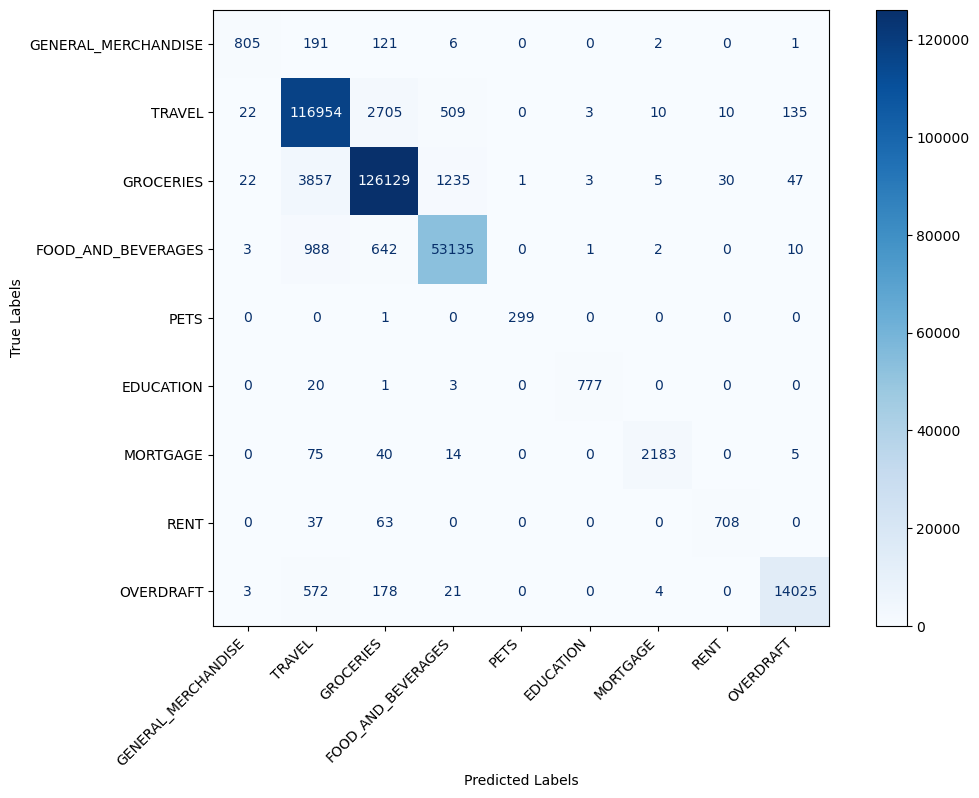

In [22]:
cm_reg = confusion_matrix(y_test, y_pred)

# Get unique class names from test_labels
class_names = test_labels.unique()

# Create a larger figure and axis
fig, ax = plt.subplots(figsize=(12, 8))  # Adjust the width and height as needed

# Plot the confusion matrix on the created axis
disp = ConfusionMatrixDisplay(confusion_matrix=cm_reg, display_labels=class_names)
disp.plot(cmap='Blues', ax=ax)  # Pass the axis to the plot function
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for readability
plt.show()


In [ ]:
# Train Random Forest model
rf = RandomForestClassifier(n_estimators=100, max_depth=50, random_state=42)
rf.fit(train_features, train_labels)

# Evaluate
y_pred_rf_train = rf.predict(train_features)
print("Random Forest Accuracy on Training:", accuracy_score(train_labels, y_pred_rf_train))
print("Random Forest F1-Score on Training:", f1_score(train_labels, y_pred_rf_train, average='weighted'))

y_pred_rf = rf.predict(test_features)
print("Random Forest Accuracy on Testing:", accuracy_score(test_labels, y_pred_rf))
print("Random Forest F1-Score on Testing:", f1_score(test_labels, y_pred_rf, average='weighted'))

Random Forest Accuracy on Training: 0.8582116906358481
Random Forest F1-Score on Training: 0.8562788644807421
Random Forest Accuracy on Testing: 0.8349118735495201
Random Forest F1-Score on Testing: 0.83191488752098


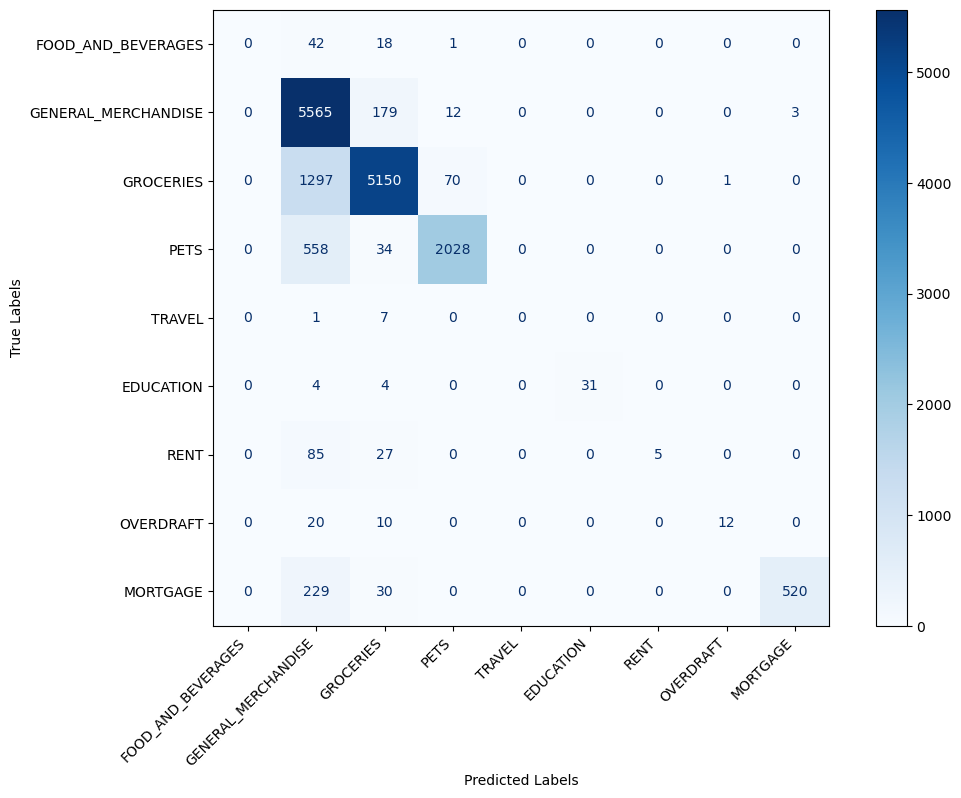

In [ ]:
cm_reg = confusion_matrix(test_labels, y_pred_rf)

# Get unique class names from test_labels
class_names = test_labels.unique()

# Create a larger figure and axis
fig, ax = plt.subplots(figsize=(12, 8))  # Adjust the width and height as needed

# Plot the confusion matrix on the created axis
disp = ConfusionMatrixDisplay(confusion_matrix=cm_reg, display_labels=class_names)
disp.plot(cmap='Blues', ax=ax)  # Pass the axis to the plot function
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for readability
plt.show()
